<a href="https://colab.research.google.com/github/HsengivS/Birds-Audio-Classification/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob

# Importing drive method from colab for accessing google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/My Drive/BIRDS_AUDIO_CLASSIFIER"

AmericanCrow  BlueJay  EasternWoodPewee  NorthernWaterthrush  Ovenbird	Veery


In [3]:
# Pandas
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

# Audio
import librosa
import librosa.display

# Plot
import matplotlib.pyplot as plt

# Utility
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools

In [4]:
data_folders = ["/content/drive/My Drive/BIRDS_AUDIO_CLASSIFIER/"+i for i in os.listdir("/content/drive/My Drive/BIRDS_AUDIO_CLASSIFIER")]
data_folders

['/content/drive/My Drive/BIRDS_AUDIO_CLASSIFIER/AmericanCrow',
 '/content/drive/My Drive/BIRDS_AUDIO_CLASSIFIER/NorthernWaterthrush',
 '/content/drive/My Drive/BIRDS_AUDIO_CLASSIFIER/Ovenbird',
 '/content/drive/My Drive/BIRDS_AUDIO_CLASSIFIER/Veery',
 '/content/drive/My Drive/BIRDS_AUDIO_CLASSIFIER/BlueJay',
 '/content/drive/My Drive/BIRDS_AUDIO_CLASSIFIER/EasternWoodPewee']

In [5]:
%%time
dataset = []
for folder in data_folders:
  label = folder.split("/")[-1]
  for filename in os.listdir(folder):
    fn = os.path.join(folder, filename)
    if librosa.get_duration(filename=fn)>=4:
      dataset.append({"filename":fn, "label":label})

CPU times: user 10.4 s, sys: 27.2 s, total: 37.6 s
Wall time: 11min 9s


In [7]:
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1581 entries, 1385 to 1159
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1581 non-null   object
 1   label     1581 non-null   object
dtypes: object(2)
memory usage: 37.1+ KB


In [9]:
dataset.label.value_counts()

BlueJay                370
AmericanCrow           280
NorthernWaterthrush    275
Ovenbird               229
Veery                  216
EasternWoodPewee       211
Name: label, dtype: int64

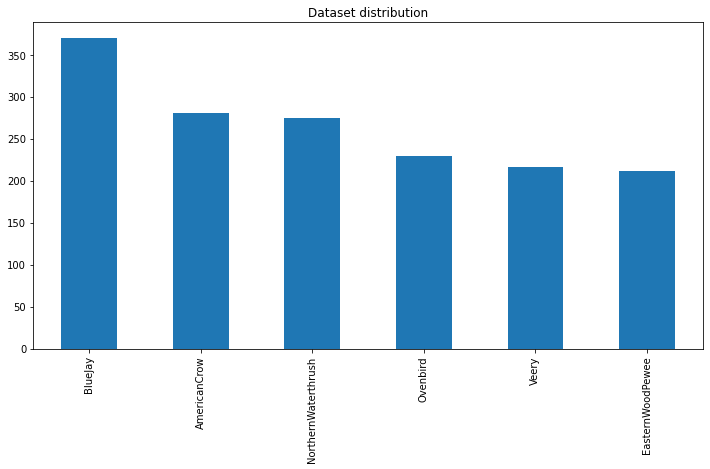

In [10]:
plt.figure(figsize=(12,6))
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

In [47]:
train, test = train_test_split(dataset, test_size=0.05, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 1501
Test: 80


Extract Audio Features

In [48]:
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, duration=4)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [49]:
extract_features(dataset.iloc[0,0]).shape

(40, 173)

In [50]:
%%time
x_train, x_test = [], []
print("Extract features from TRAIN  and TEST dataset")
for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx]))
    
print("here------------")

# print(x_train[0:2])

x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
print(22222222222222222222222222222222222222)
print("X train:", x_train.shape)
print("X test:", x_test.shape)

  0%|          | 0/1501 [00:00<?, ?it/s]

Extract features from TRAIN  and TEST dataset


100%|██████████| 80/80 [00:42<00:00,  1.88it/s]

here------------
22222222222222222222222222222222222222
X train: (1501, 40, 173)
X test: (80, 40, 173)
CPU times: user 4min 50s, sys: 3min 8s, total: 7min 58s
Wall time: 14min 25s


Encode Labels

In [51]:
%%time
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

CPU times: user 929 µs, sys: 1.55 ms, total: 2.48 ms
Wall time: 1.25 ms


Compute class weights

In [52]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

# class_weights


Shape the input

In [53]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print()
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (1501, 40, 173, 1)
Y train: (1501, 6)

X test: (80, 40, 173, 1)
Y test: (80, 6)


Build Model

In [54]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 39, 172, 16)       80        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 19, 86, 16)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 41, 64)        

In [55]:
# Compile
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Fit

In [56]:
%%time
history = model.fit(x_train, y_train,
              batch_size=100,
              epochs=300,
              validation_data=(x_test, y_test),
              shuffle=True)

# %%time
# history = model.fit(x_train, y_train,
#               batch_size=128,
#               epochs=10,
#               validation_data=(x_test, y_test),
#               class_weight=class_weights,
#               shuffle=True)

Epoch 1/300
16/16 [==============================] - 0s 22ms/step - loss: 5.2351 - accuracy: 0.1845 - val_loss: 1.9637 - val_accuracy: 0.1875
Epoch 2/300
16/16 [==============================] - 0s 13ms/step - loss: 2.2612 - accuracy: 0.1885 - val_loss: 1.7845 - val_accuracy: 0.1625
Epoch 3/300
16/16 [==============================] - 0s 11ms/step - loss: 1.8748 - accuracy: 0.2192 - val_loss: 1.7728 - val_accuracy: 0.2500
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 1.8342 - accuracy: 0.2418 - val_loss: 1.7420 - val_accuracy: 0.2250
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 1.7596 - accuracy: 0.2712 - val_loss: 1.7123 - val_accuracy: 0.3000
Epoch 6/300
16/16 [==============================] - 0s 12ms/step - loss: 1.7215 - accuracy: 0.2845 - val_loss: 1.7003 - val_accuracy: 0.3625
Epoch 7/300
16/16 [==============================] - 0s 11ms/step - loss: 1.6966 - accuracy: 0.3031 - val_loss: 1.6796 - val_accuracy: 0.3000
Epoch 

In [42]:
  # Save model and weights
model_name = "birds_classify_v3.h5"
model.save(model_name)
print('Saved trained model at %s ' % model_name)

Saved trained model at birds_classify_v3.h5 


In [58]:
# Evaluate the model
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

3/3 [==============================] - 0s 3ms/step - loss: 1.1347 - accuracy: 0.6875
Test loss: 1.1347371339797974
Test accuracy: 0.6875


In [44]:
# classification report
predictions = model.predict(x_test, verbose=1)

5/5 [==============================] - 0s 2ms/step


In [45]:
y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])

In [ ]:
print(classification_report(y_pred, y_true))

                     precision    recall  f1-score   support

       AmericanCrow       0.77      0.83      0.80        52
            BlueJay       0.84      0.78      0.81        68
   EasternWoodPewee       0.68      0.64      0.66        50
NorthernWaterthrush       0.42      0.66      0.51        38
           Ovenbird       0.68      0.57      0.62        63
              Veery       0.79      0.65      0.71        46

           accuracy                           0.69       317
          macro avg       0.70      0.69      0.69       317
       weighted avg       0.71      0.69      0.70       317



In [ ]:
# confusion matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(11, 11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)
    plt.tight_layout()

    plt.show()

In [ ]:
cnf_matrix = confusion_matrix(y_pred, y_true)
cnf_matrix = cnf_matrix.astype(float) / cnf_matrix.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cnf_matrix, classes)

NameError: ignored